##### XGBoost: its hyper-parameters, doing cross-validation, visualizing the trees and in the end how it can also be used as a Feature Selection technique.

1. labelencoder for categorical values.
1. Xgboost is capable of handling the missing values internally

In [21]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


from scipy import stats
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv("train/train.csv", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
df_features = pd.read_csv("features/features.csv",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
df_stores = pd.read_csv("stores.csv", names=['Store','Type','Size'],sep=',', header=0)
df_train = df_train.merge(df_stores, how='left').merge(df_features, how='left')

In [7]:

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
#MultiColumnLabelEncoder(columns = ['isHoliday','Type']).fit_transform(df_train)

In [9]:
df_train = MultiColumnLabelEncoder(columns = ['isHoliday','Type']).fit_transform(df_train)

In [10]:
df_train.head()

,Store,Dept,Date,weeklySales,isHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,0,0,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,1,0,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,0,0,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,0,0,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,0,0,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [11]:
X, y = df_train.drop(columns = ['weeklySales','Date']).iloc[:],df_train['weeklySales'].iloc[:]

In [12]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [15]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

[00:19:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:20:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


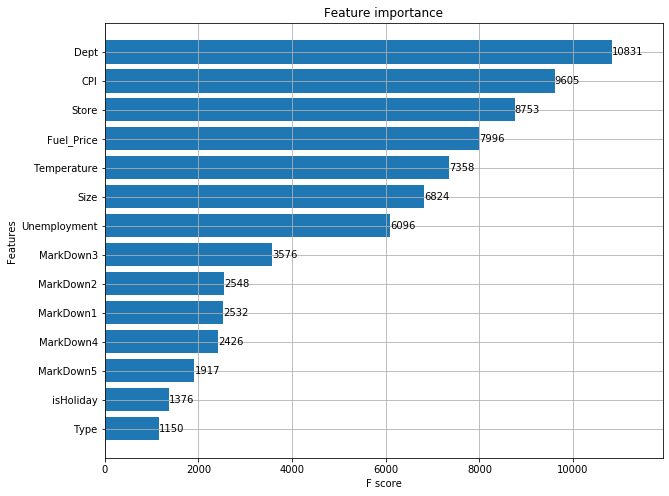

In [20]:
'''xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))'''

train_y = df_train['weeklySales']
train_X = df_train.drop(["weeklySales", "Date"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1}

dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
remain_num = 99

fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(model, max_num_features=remain_num, height=0.8, ax=ax)
plt.show()

In [ ]:
dataSF = np.array(dataplot1)
describedataSF = stats.describe(dataSF)
describedataSF